In [1]:
# import packages

import torch
from collections import OrderedDict

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams.update({'font.family': 'serif', 'font.size': 10})
matplotlib.rcParams['text.usetex'] = True
from matplotlib.lines import Line2D

from scipy.interpolate import griddata
from scipy import integrate
import time

np.random.seed(1234)

In [2]:
# CUDA support 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [98]:
# compute true solution using scipy.integrate.solve_ivp

def func(t, r):
    x, y = r
    dx_t = 2 * x - 2 * x * y
    dy_t = 1 * x * y - 1 * y
    return dx_t, dy_t


def gen_truedata_1():
    t = np.linspace(0, 10, 10001)

    sol = integrate.solve_ivp(func, (0, 10), (0.15, 1), t_eval=t)
    x_true, y_true = sol.y
    t = sol.t
    x_true = x_true.reshape(10001, 1)
    y_true = y_true.reshape(10001, 1)

    return x_true, y_true, t


true_solution_1 = gen_truedata_1()

In [99]:
def gen_truedata_2():
    t = np.linspace(0, 10, 10001)

    sol = integrate.solve_ivp(func, (0, 10), (1.15, 2), t_eval=t)
    x_true, y_true = sol.y
    t = sol.t
    x_true = x_true.reshape(10001, 1)
    y_true = y_true.reshape(10001, 1)

    return x_true, y_true, t


true_solution_2 = gen_truedata_2()

In [100]:
# generate data from the solution by using a random subset of true_solution

training_indices = random.sample(range(10000), 50)

# need to choose these as pairs
training_data_1 = [(true_solution_1[0][index], true_solution_1[1][index], true_solution_1[0][index + 1], true_solution_1[1][index + 1]) for index in training_indices]

In [101]:
# generate data from the solution by using a random subset of true_solution

training_indices = random.sample(range(10000), 50)

# need to choose these as pairs
training_data_2 = [(true_solution_2[0][index], true_solution_2[1][index], true_solution_2[0][index + 1], true_solution_2[1][index + 1]) for index in training_indices]

In [102]:
# want inv_training_data to be a torch.tensor

training_data = training_data_1 + training_data_2

inv_training_data = torch.tensor(training_data, requires_grad=True).float().to(device)

In [103]:
# define the deep neural network

class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        
        super().__init__()

        # DE parameter initialization
        # self.alpha = torch.nn.Parameter(torch.tensor(10.0, requires_grad=True))
        # self.beta = torch.nn.Parameter(torch.tensor(10.0, requires_grad=True))
        # self.gamma = torch.nn.Parameter(torch.tensor(10.0, requires_grad=True))
        # self.delta = torch.nn.Parameter(torch.tensor(10.0, requires_grad=True))

        # DE random parameter initialization
        self.alpha = torch.nn.Parameter(torch.tensor(random.uniform(0, 10), requires_grad=True))
        self.beta = torch.nn.Parameter(torch.tensor(random.uniform(0, 10), requires_grad=True))
        self.gamma = torch.nn.Parameter(torch.tensor(random.uniform(0, 10), requires_grad=True))
        self.delta = torch.nn.Parameter(torch.tensor(random.uniform(0, 10), requires_grad=True))
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        
        # x = (t, y0)
        return self.layers(x)

In [104]:
# define the PINN: physics-informed neural network

class PINN():

    def __init__(self, X_pinn, X_semigroup, X_smooth, layers, T):

        # neural network architecture
        self.layers = layers
        self.dnn = DNN(layers).to(device)
        self.params = {"alpha" : [], "beta" : [], "gamma" : [], "delta" : []}
        
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)

        # inverse training data
        self.inv_data = inv_training_data.to(device)
        self.t = torch.tensor([[0.001] for i in range(100)]).to(device)

        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        # optimization
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), lr=0.1, max_iter=50000, max_eval=50000, 
            history_size=50, tolerance_grad=0, tolerance_change=0, 
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # The M(t, y0) = y0 + t N(t, y0) scheme seems to drastically increase the accuracy
        # This works perfectly fine with automatic differentiation

        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivative of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for i in range(2)]
        
        for i, vec in enumerate(vectors):
            
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        # in our case, dy1/dt = alpha * y1 - beta * (y1 * y2), dy2/dt = gamma * (y1 * y2) - delta * y2
        loss_pinn1 = torch.mean((deriv_pred[0] - self.dnn.alpha * y_pred[:,0:1] + self.dnn.beta * (y_pred[:,0:1] * y_pred[:,1:2])) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - self.dnn.gamma * (y_pred[:,0:1] * y_pred[:,1:2]) + self.dnn.delta * y_pred[:,1:2]) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2 
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)

        # The Inverse loss, should be able to use tuples (y_0, t) from scipy as input
        loss_inverse = torch.sum((self.net_y(self.t, self.inv_data[:, 0:2, 0]) - self.inv_data[:, 2:4, 0])** 2)
        
        # loss_inverse = torch.mean([(self.net_y(torch.tensor([[0.01]]), torch.reshape(torch.tensor([inv_training_data[i][0], inv_training_data[i][1]]), (1, 2))) - (inv_training_data[i][2], inv_training_data[i][3]))** 2 for i in range(len(inv_training_data))])
        
        # added loss_inverse of inverse problem
        loss = loss_pinn + loss_smooth + loss_semigroup + 10000 * loss_inverse
        
        loss.backward()
        self.iter += 1
        
        if self.iter % 100 == 0:
            self.params["alpha"].append(self.dnn.alpha.item())
            self.params["beta"].append(self.dnn.beta.item())
            self.params["gamma"].append(self.dnn.gamma.item())
            self.params["delta"].append(self.dnn.delta.item())

            print(
                f"Iter {self.iter}, Loss: {loss.item():.5f}, Loss_pinn: {loss_pinn.item():.5f} " \
                f"Loss_smooth: {loss_smooth.item():.5f}, Loss_semigroup: {loss_semigroup.item():.5f} " \
                f"Loss_inv: {10000 * loss_inverse.item():.5f} " \
                f"alpha: {self.dnn.alpha.item():.5f}, beta: {self.dnn.beta.item():.5f}, gamma: {self.dnn.gamma.item():.5f}, delta: {self.dnn.delta.item():.5f} "
            )
        
        return loss
    
    
    def train(self):
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

### Setup data example

In [105]:
""" Use a DNN with 3 hidden layers and 50 neurons per layer for Lotka-Volterra """

layers = [3, 64, 64, 64, 64, 64, 2]

T = 1
max_y0 = 5

# standard PINN loss function training samples
N_pinn = 10000
N_semigroup = 10000
N_smooth = 10000


t_pinn = np.random.uniform(0, T, (N_pinn, 1))
y_pinn = np.random.uniform(0, max_y0, (N_pinn, 2))
X_pinn = np.hstack([t_pinn, y_pinn])


r1 = np.random.uniform(0, 1, N_semigroup)
r2 = np.random.uniform(0, 1, N_semigroup)
s_semigroup, t_semigroup = np.sqrt(r1) * (1 - r2), r2 * np.sqrt(r1)
s_semigroup, t_semigroup = T * s_semigroup[:, np.newaxis], T * t_semigroup[:, np.newaxis]
y_semigroup = np.random.uniform(0, max_y0, (N_semigroup, 2))
X_semigroup = np.hstack([s_semigroup, t_semigroup, y_semigroup])


t_smooth = np.random.uniform(0, T, (N_smooth, 1))
y_smooth = np.random.uniform(0, max_y0, (N_smooth, 2))
X_smooth = np.hstack([t_smooth, y_smooth])

In [106]:
# initialize the PINN

model = PINN(X_pinn, X_semigroup, X_smooth, layers, T)

In [108]:
# train the model from scratch or load an already trained model (next cell)

%%time
               
model.train()

CPU times: user 257 ms, sys: 1.92 ms, total: 259 ms
Wall time: 257 ms


In [109]:
model.params["delta"]

[1.2559326887130737,
 0.22014103829860687,
 0.2539496421813965,
 0.33930903673171997,
 0.4616973102092743,
 0.5559467077255249,
 0.6052092909812927,
 0.6400206685066223,
 0.710089921951294,
 0.7441238760948181,
 0.7829760909080505,
 0.8459007740020752,
 0.906757116317749,
 0.92557692527771,
 0.9322914481163025,
 0.935763418674469,
 0.9286128282546997,
 0.9401037096977234,
 0.9457122683525085,
 0.9570355415344238,
 0.9674064517021179,
 0.9687837362289429,
 0.9694754481315613,
 0.9729471802711487,
 0.9759065508842468,
 0.977972149848938,
 0.9771386981010437,
 0.979220449924469,
 0.9816805124282837,
 0.9842084050178528,
 0.9837515950202942,
 0.9832921624183655]

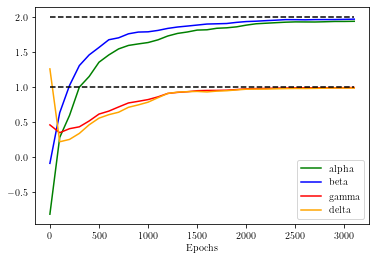

In [121]:
# plot inverse problem convergence

t = [100*i for i in range(len(model.params["alpha"]))]
alpha = model.params["alpha"]
beta = model.params["beta"]
gamma = model.params["gamma"]
delta = model.params["delta"]

alpha_true = [2 for i in range(len(t))]

gamma_true = [1 for i in range(len(t))]

plt.plot(t, alpha, color="green", label="alpha")
plt.plot(t, beta, color="blue", label="beta")
plt.plot(t, gamma, color="red", label='gamma')
plt.plot(t, delta, color="orange", label="delta")

plt.plot(t, alpha_true, color="black", linestyle="dashed")
plt.plot(t, gamma_true, color="black", linestyle="dashed")

plt.legend(loc='lower right')
plt.xlabel("Epochs")

plt.show()

In [ ]:
# save the model

import os

path = os.getcwd()

torch.save(model.dnn.state_dict(), path + '/model_new.pt')

In [ ]:
# load an already existing model, in this case in the same folder on GitHub

import os

path = os.getcwd()

model.dnn.load_state_dict(torch.load(path + '/model_new.pt'))

# print(model.dnn.state_dict())

<All keys matched successfully>

## Predict and Plot the Solution

In [ ]:
# visualization functions for simple ODEs, we don't use this for Lotka-Volterra

def generate_figure(figsize, xlim, ylim):
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return fig, ax


def plot_ode_solution(ax, y, *args, **kwargs):
    
    ax.plot(y[:,0], y[:,1], '.-', *args, **kwargs)
    
    return ax

In [ ]:
# predict the solution of the Lotka-Volterra ODE

def predict_standard(model, y0, max_t_pred, delta_t):
    
    times = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
    times = times[:,np.newaxis]
    
    y0 = np.array([y0 for _ in range(len(times))])
    trajectory =  model.predict(times, y0)
    
    return trajectory


def predict_dac(model, y0, max_t_pred, delta_t):
    """
    detla_t should devide model.max_t to guarantee equidistant steps
    """
    times = np.arange(0, model.T + delta_t, delta_t)[1:]
    times = times[:,np.newaxis]
    n_resets = int(np.ceil(max_t_pred / model.T))
    
    trajectory = np.array([y0])
    
    for _ in range(n_resets):
        
        y0 = trajectory[-1]
        y0 = np.array([y0 for _ in range(len(times))])
        segment =  model.predict(times, y0)
        trajectory = np.vstack([trajectory, segment])
    
    return trajectory

In [ ]:
# Compute the solution for a given initial condition
# Note that max_t in training is 1

y0 = [0.15, 1]
max_t_pred = 40
delta_t = 0.05

validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_standard = predict_standard(model, y0, max_t_pred, delta_t)

TypeError: ignored

In [ ]:
# plot the results and compare with the true solution

#plt.xlabel("t")
#plt.ylabel("population")

t = np.linspace(0, 40, 801)
x_true = true_solution[:, 0]
y_true = true_solution[:, 1]
plt.plot(t, x_true, color="black")
plt.plot(t, y_true, color="blue")


x_pred = validation_dac[:, 0]
y_pred = validation_dac[:, 1]

plt.plot(t, x_pred, color="red", linestyle="dashed")
plt.plot(t, y_pred, color="orange", linestyle="dashed")
# plt.legend()
plt.show()

TypeError: ignored

In [111]:
# might have to install these packages for visualization purposes before running the previous cell

! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0 libkpathsea6
  libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern f

In [114]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 cm-super-minimal all 0.3.4-15 [5,811 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 cm-super all 0.3.4-15 [18.7 MB]
Fetched 24.5 MB in 1s (20.0 MB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 158682 files and directories currently installed.)
Preparing to unpack .../cm-super-minimal_0.3.4-15_all.deb ...
Unpacking cm-super-minimal (0.3.4-15) ...
Selecting p